Example fitting a RHESSI observation of an M flare from [Flecther et. 2007](https://doi.org/10.1086/510446), flare #3 M1.2 (old GOES/XRS scaling). This flare has attenuator (A1) in during the flare and pre-flare background time - which is unusual and so background selection/subtraction is more like a shutter out flare.

* files generated by [get_fl20021005_a1.pro](https://github.com/ianan/sks_examples/blob/main/get_fl20021005_a1.pro)
* sunkit-spex fit for the summed detectors [sks_fit_rhessi_flare.ipynb](https://github.com/ianan/sks_examples/blob/main/sks_fit_rhessi_flare.ipynb)

Here we are trying to simultenously fit the data from multiple detectors, the model scaled by factors to represent the systematic difference between detectors. 

Mind that sunkit-spex currently can only work with RHESSI files made in sswidl that have sum_flag=1, even if the file only contains one detector https://github.com/sunpy/sunkit-spex/issues/132

* 27-Oct-2025   IGH
---

In [1]:
from astropy.time import Time, TimeDelta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sunpy.io.special import read_genx

# Works with legacy code in sunkit-sepx version 0.4.1.dev52
from sunkit_spex.extern.rhessi import RhessiLoader
from sunkit_spex.legacy.fitting.fitter import Fitter

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

plt.rcParams.update({'font.size': 18,'mathtext.default':"regular"})

In [2]:
# Use the better fit models?
from sunkit_spex.legacy import thermal
ch_dir='../fvth_stuff/better_chxdb/'
# Or from https://github.com/ianan/fvth_stuff/tree/main/better_chxdb
thermal.LINE_GRID=thermal.setup_line_parameters(ch_dir+'chianti_lines_2_12_unity_v1102_t101.sav') 
thermal.CONTINUUM_GRID=thermal.setup_continuum_parameters(ch_dir+'chianti_cont_1_250_unity_v1102_t101.sav')

In [3]:
# Some setup for sunxspex
time_profile_size = (9,6)
spec_single_plot_size = (6,8)
spec_three_plot_size = (15,8)
spec_plot_size = (16,10)
spec_font_size = 18
default_font_size = 10
xlims, ylims = [3,100], [5e-2,3e4]
tol = 1e-5

# Where are the spec and srm fits files
# Just try 2 to beging with....
_dir = "fits/"
specname1=_dir+"20021005_103800_spec_d1_sf1.fits"
srmname1=_dir+"20021005_103800_srm_d1_sf1.fits"
specname3=_dir+"20021005_103800_spec_d3_sf1.fits"
srmname3=_dir+"20021005_103800_srm_d3_sf1.fits"
tmk2kev=0.086164

In [4]:
# Flare peak and background times
ftims=Time(['2002-10-05T10:41:20.000','2002-10-05T10:42:24.000'],format='isot')
btims=Time(['2002-10-05T10:38:32.000','2002-10-05T10:40:32.000'],format='isot')
print(ftims)
print(btims)


['2002-10-05T10:41:20.000' '2002-10-05T10:42:24.000']
['2002-10-05T10:38:32.000' '2002-10-05T10:40:32.000']


In [5]:
spec1 = RhessiLoader(spectrum_fn=specname1, srm_fn=srmname1)
spec3 = RhessiLoader(spectrum_fn=specname3, srm_fn=srmname3)

In [6]:
spec1.update_background_times(btims[0],btims[1])
spec1.update_event_times(ftims[0],ftims[1])

spec3.update_background_times(btims[0],btims[1])
spec3.update_event_times(ftims[0],ftims[1])

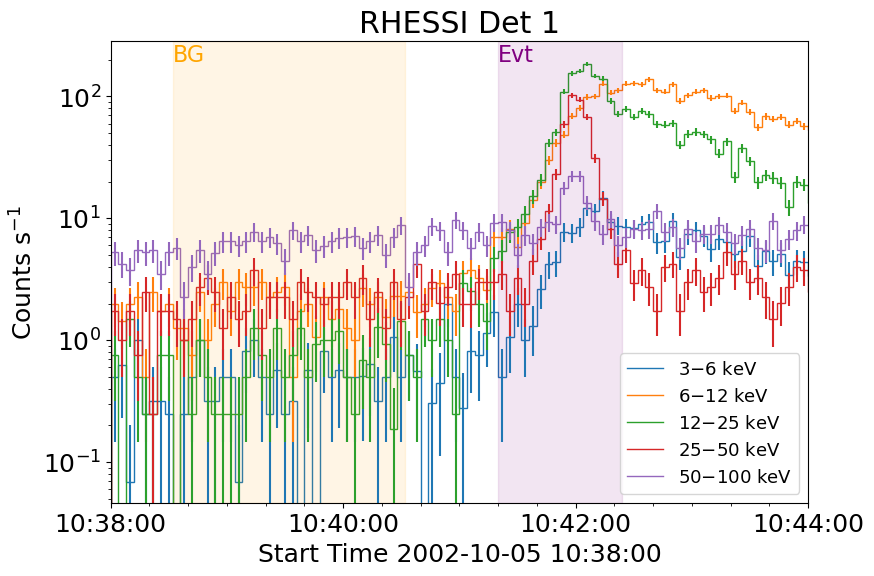

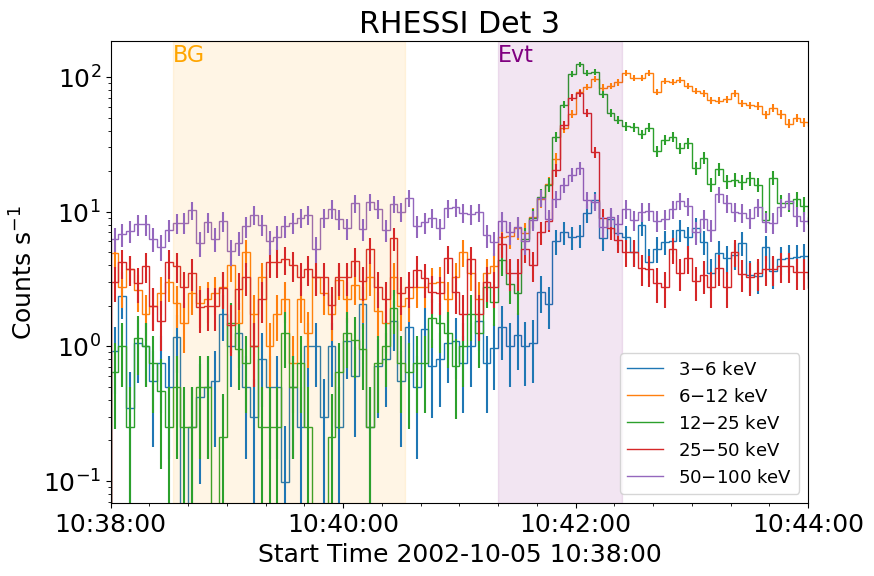

In [7]:
tr=Time(['2002-10-05T10:38:00.000','2002-10-05T10:44:00.000'],format='isot')
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)
ax=spec1.lightcurve(energy_ranges=[[3,6], [6,12], [12,25], [25,50],[50,100]])
ax.set_xlim(tr[0].datetime,tr[1].datetime)
ax.set_xlabel("Start Time "+tr[0].iso[:19])
ax.set_title("RHESSI Det 1")
ax.xaxis.set_minor_locator(matplotlib.dates.SecondLocator(interval=20))
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=2))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))
plt.show()
plt.rcParams['font.size'] = default_font_size

plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)
ax=spec3.lightcurve(energy_ranges=[[3,6], [6,12], [12,25], [25,50],[50,100]])
ax.set_xlim(tr[0].datetime,tr[1].datetime)
ax.set_xlabel("Start Time "+tr[0].iso[:19])
ax.set_title("RHESSI Det 3")
ax.xaxis.set_minor_locator(matplotlib.dates.SecondLocator(interval=20))
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=2))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))
plt.show()
plt.rcParams['font.size'] = default_font_size

In [8]:
#  Now do the fitting
fitter = Fitter(spec1,spec3)
fitter.model = "C*(f_vth+thick_fn)"
fitter.loglikelihood = "cstat"

fitter.params["C_spectrum1"] = "frozen"
fitter.params["C_spectrum2"] = "free"

fitter.show_params



Param,Status,Value,Bounds,Error
,,,"(min, max)","(-, +)"
str22,str26,float64,object,object
T1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
EM1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
total_eflux1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
index1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
e_c1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
C_spectrum1,frozen,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
T1_spectrum2,tie_T1_spectrum1,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
EM1_spectrum2,tie_EM1_spectrum1,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"


In [9]:
# Fit setup and ranges optimised for this flare
# As A1 only fit > 6keV
fitter.energy_fitting_range = [6,15]
fitter.params["T1_spectrum1"] = {"Value":22, "Bounds":(10, 30)}
fitter.params["EM1_spectrum1"] = {"Value":10, "Bounds":(1e-1, 1e3)}
fitter.params["total_eflux1_spectrum1"] = {"Status":"fix", "Value":0.1, "Bounds":(1e-3, 1e2)}
fitter.params["index1_spectrum1"] = {"Status":"fix", "Value":6, "Bounds":(2, 12)}
fitter.params["e_c1_spectrum1"] = {"Status":"fix", "Value":20, "Bounds":(5, 30)}
spec_fit = fitter.fit()

# Then non-thermal fit higher energy
fitter.energy_fitting_range = [15,45]
fitter.params["T1_spectrum1"] = "fix"
fitter.params["EM1_spectrum1"] = "fix"
fitter.params["total_eflux1_spectrum1"] = "free"
fitter.params["index1_spectrum1"] = "free"
fitter.params["e_c1_spectrum1"] = "free"
spec_fit = fitter.fit()

# The do the full range
fitter.energy_fitting_range = [6,45]
fitter.params["T1_spectrum1"] = "free"
fitter.params["EM1_spectrum1"] = "free"
fitter.params["total_eflux1_spectrum1"] = "free"
fitter.params["index1_spectrum1"] = "free"
fitter.params["e_c1_spectrum1"] = "free"
spec_fit = fitter.fit()

# fitter.show_params
# fitted parameters
print(spec_fit)

[23.55241338840957, 14.345903406097865, 0.8650739655126368, 5.640562839154811, 20.015966748386028, 1.0, 23.55241338840957, 14.345903406097865, 0.8650739655126368, 5.640562839154811, 20.015966748386028, 0.9934352496295877]


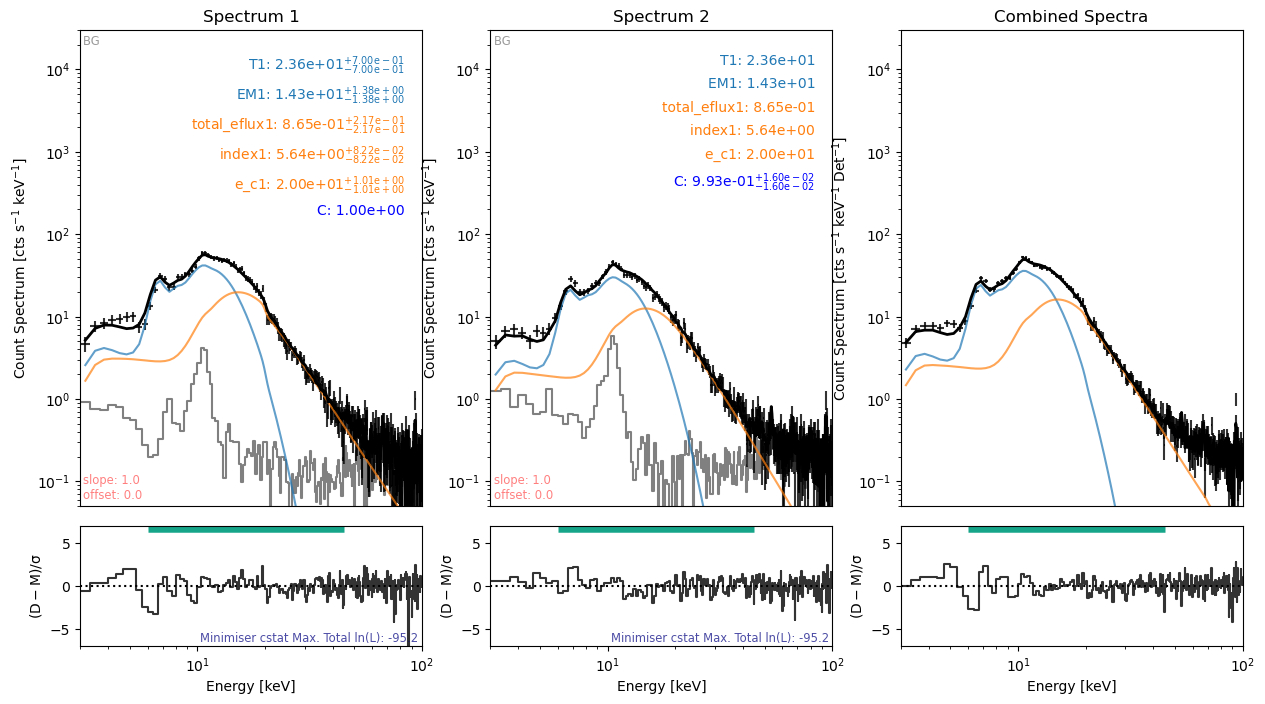

In [10]:
plt.figure(figsize=spec_three_plot_size)
axes, res_axes = fitter.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()

In [12]:
# Now do the mcmc
# This will get progressively slower the more spectra we add....
mcmc_result = fitter.run_mcmc(steps_per_walker=400,walker_spread='mag_order')

100%|██████████| 400/400 [02:25<00:00,  2.74it/s]


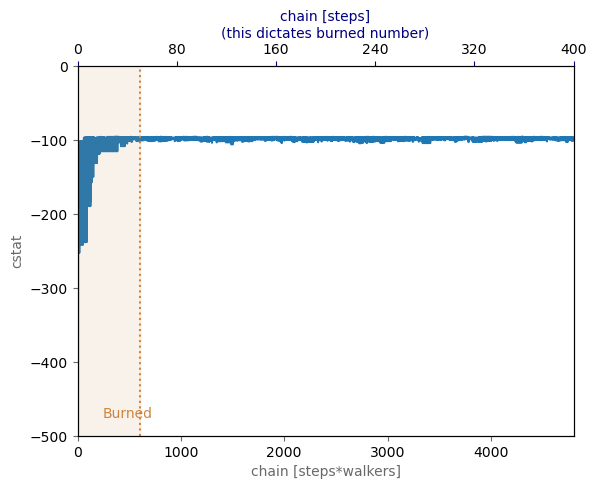

In [13]:
# Look at the log probability to see if enough runs to get stable solution
# Get rid of/burn the first 50 runs in this case
fitter.burn_mcmc = 50
plt.figure()
fitter.plot_log_prob_chain()
plt.ylim([-500,0])
plt.show()

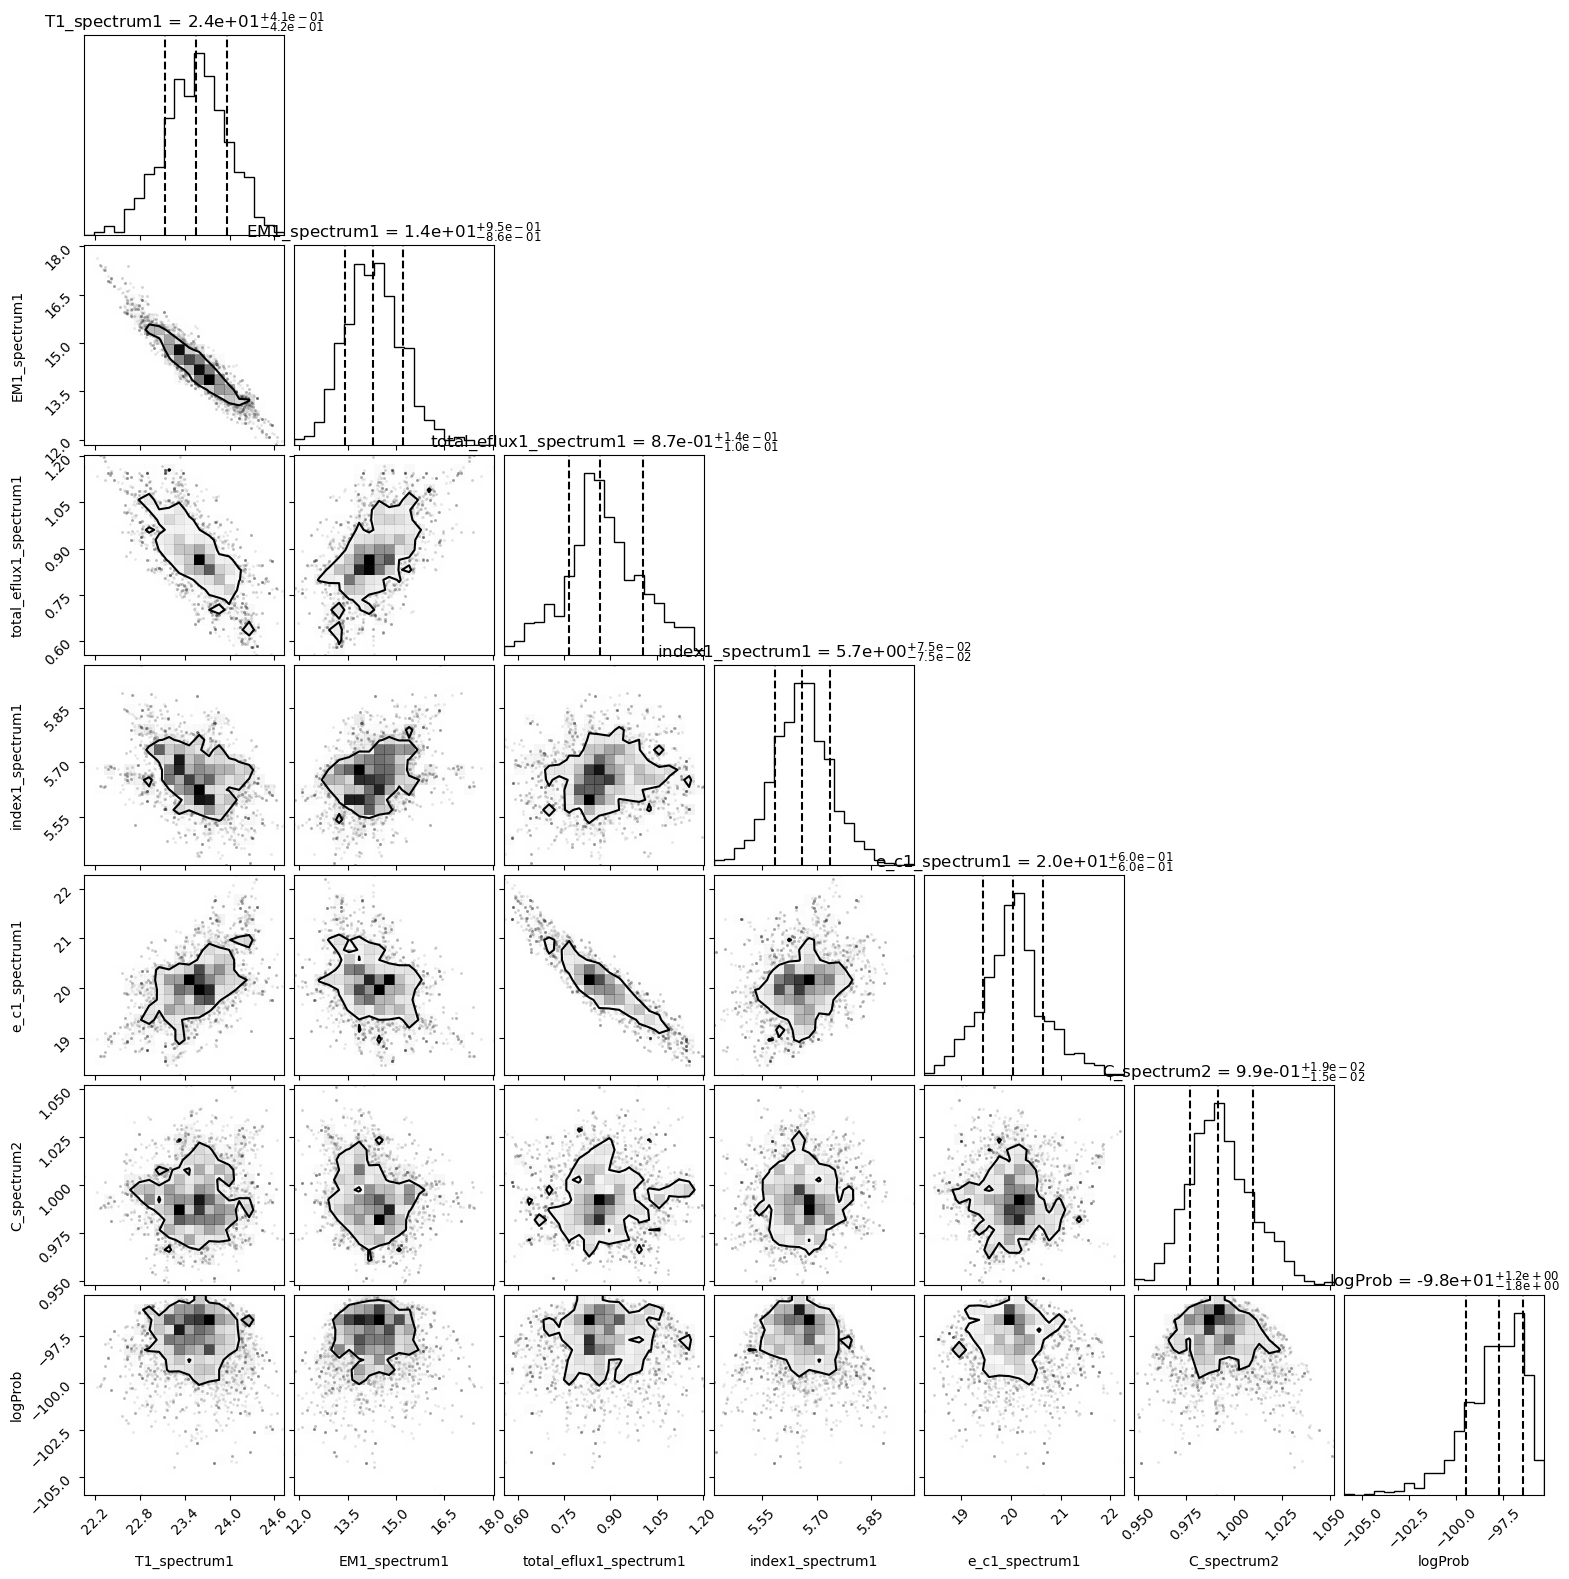

In [14]:
# Look at the results via the corner plot
corner_plot = fitter.corner_mcmc()

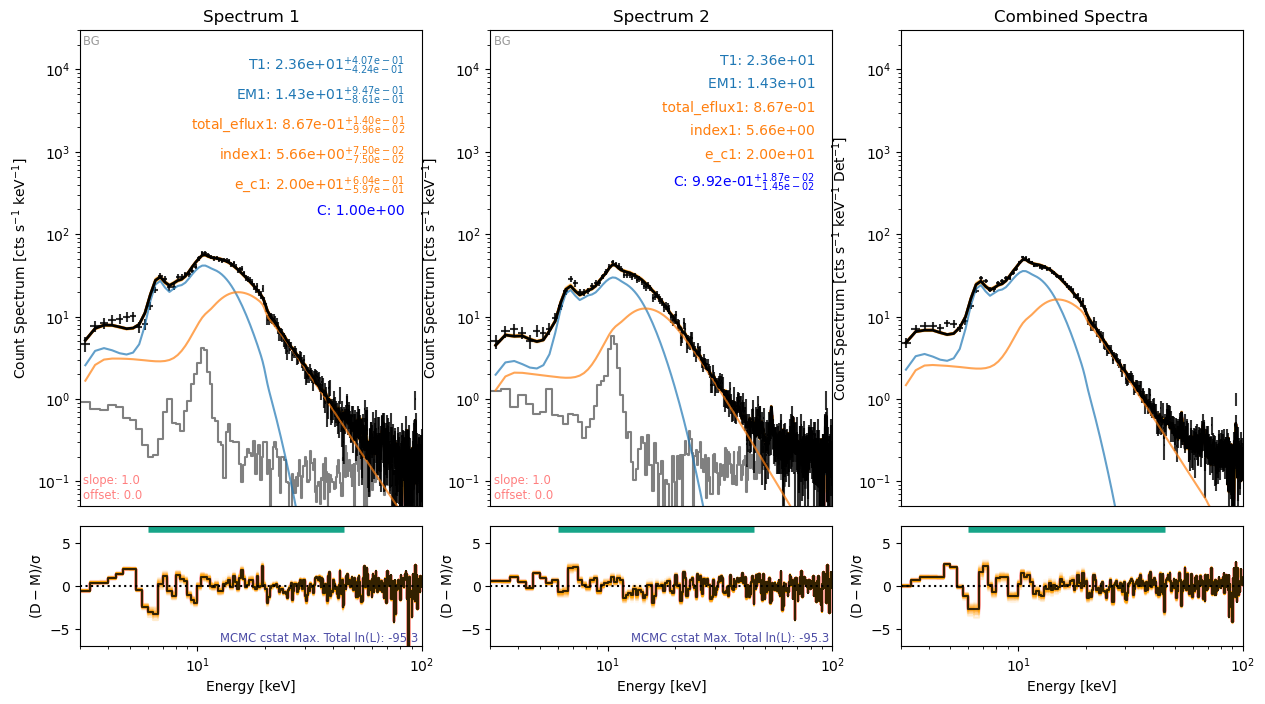

In [15]:
# Plot the spectrum using the mcmc fit results
plt.figure(figsize=spec_three_plot_size)
axes, res_axes = fitter.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()